# Advanced Lane Finding Project

## The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
* Video pipeline


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# local modules
import camera
import pipeline_functions as pf
import viz
import line
%matplotlib inline


# Camera calibration


The camera calibration code is found in camera.py module. The calibration is performed on a list of calibration images. Each image shows a chessboard at a different orientation. The calibration process is comprised of two stages:

1) Convert the image to gray: To convert the image from 3D to 2D. The calibration process is the same in all image channels.  

2) Find chessboard corners: By finding the (x,y) coordinates of the chessboard corners. This process is performed on all calibration images to collect a list of chesscorners at different orientations.

3) Camera clibration: which is the process that takes all corners found in step 2) and the the ideal corner locations and return the calibration matrix that can be used to correct (undistort) images taken by the same camera used to take the calibration images

The code below iterates over all calibration images and then undistort them using the calibration matrix "mtx" found by cv2.calibrateCamera function.


Failed to find corner points in ./camera_cal/calibration5.jpg
Failed to find corner points in ./camera_cal/calibration4.jpg
Failed to find corner points in ./camera_cal/calibration1.jpg
17 of 20 of calibration files are processed successfully


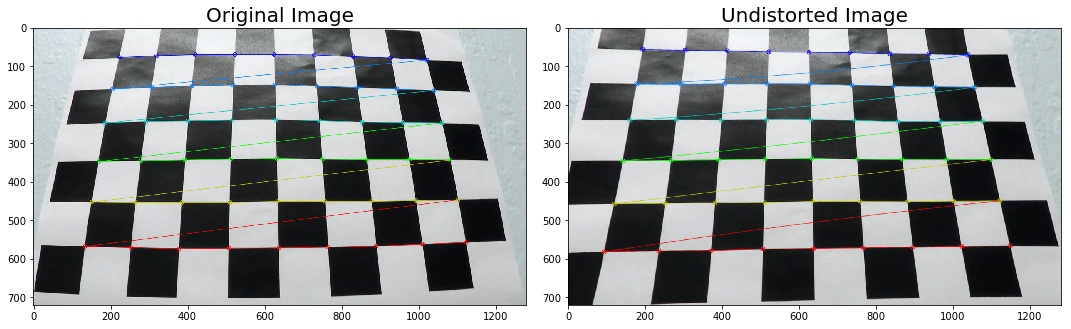

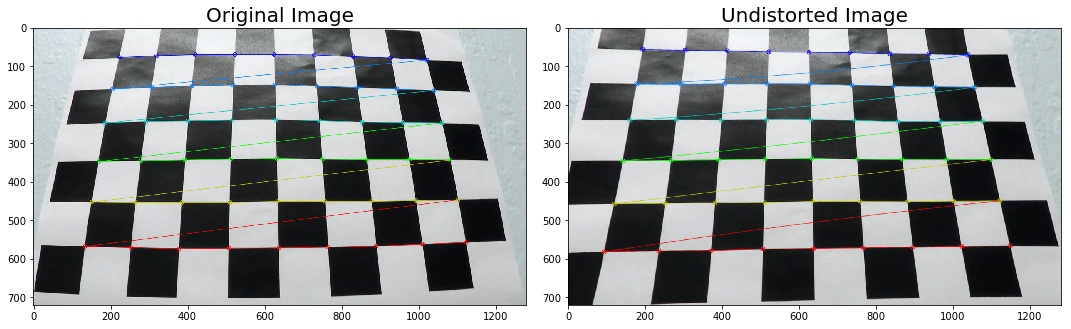

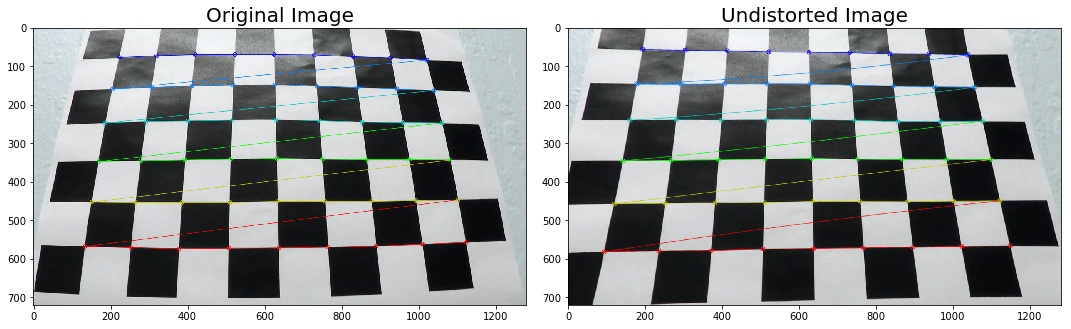

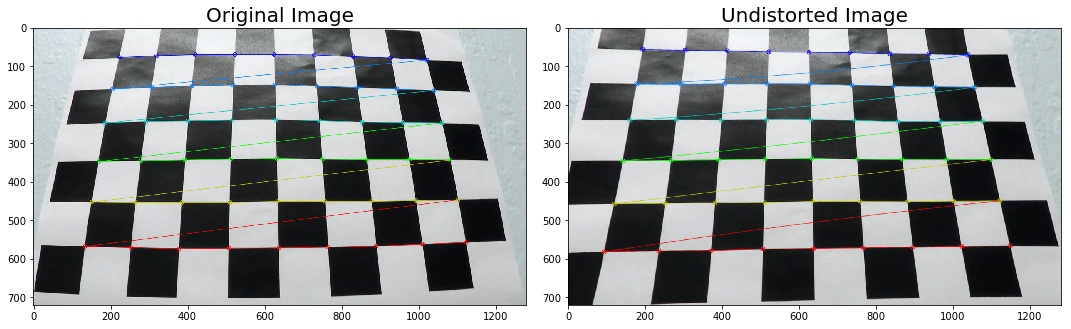

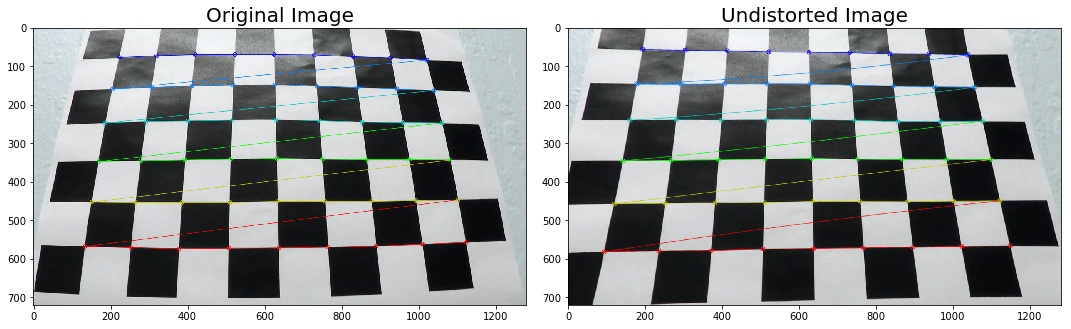

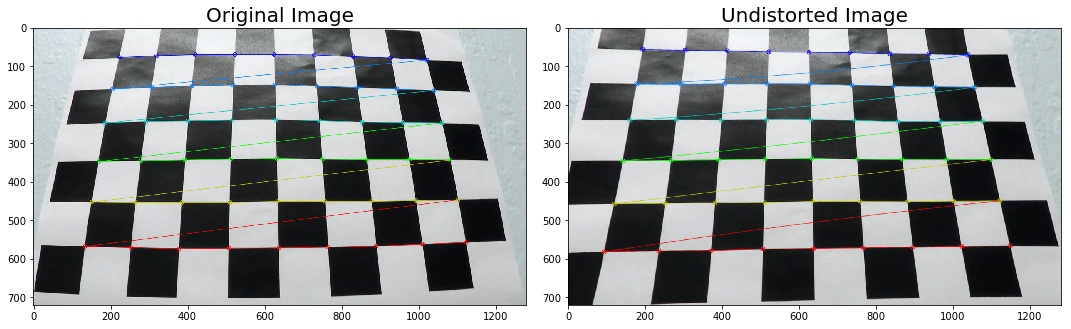

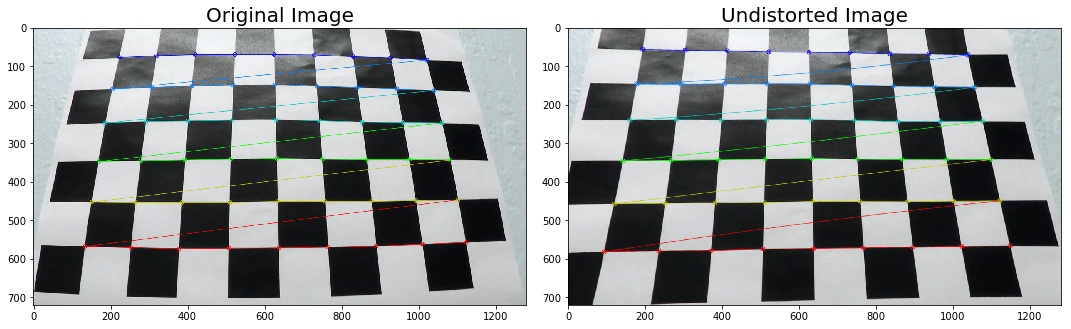

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


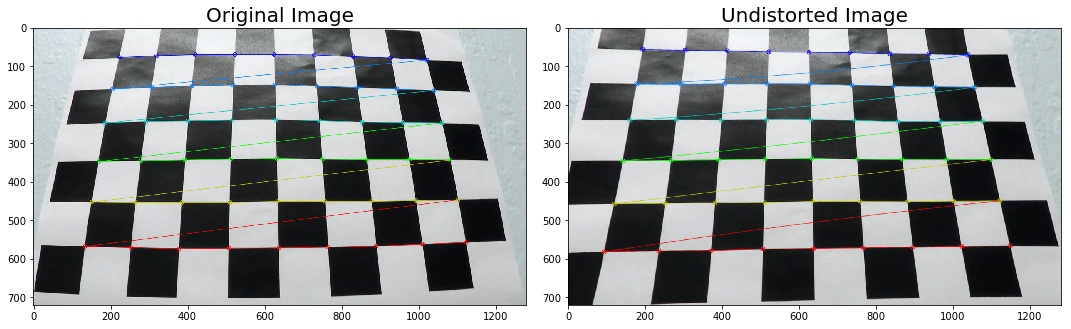

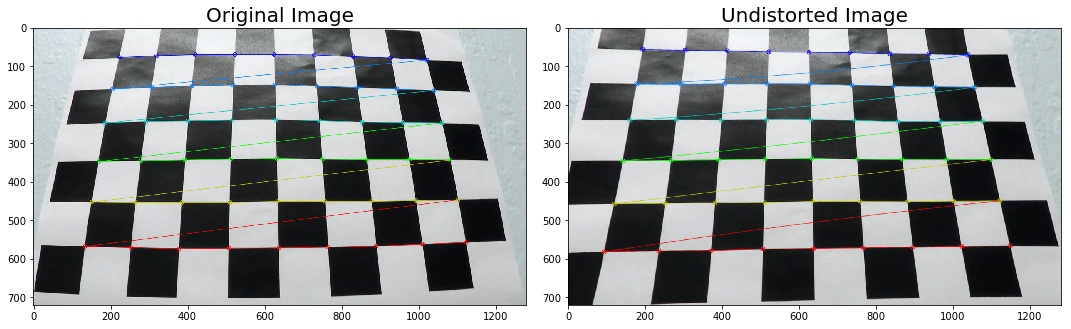

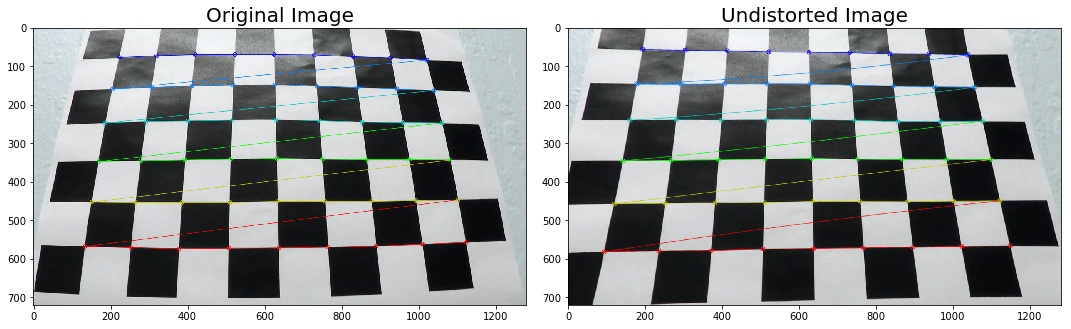

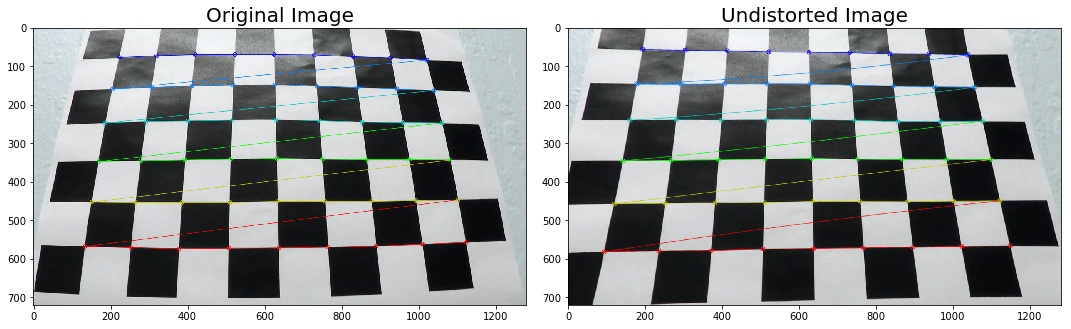

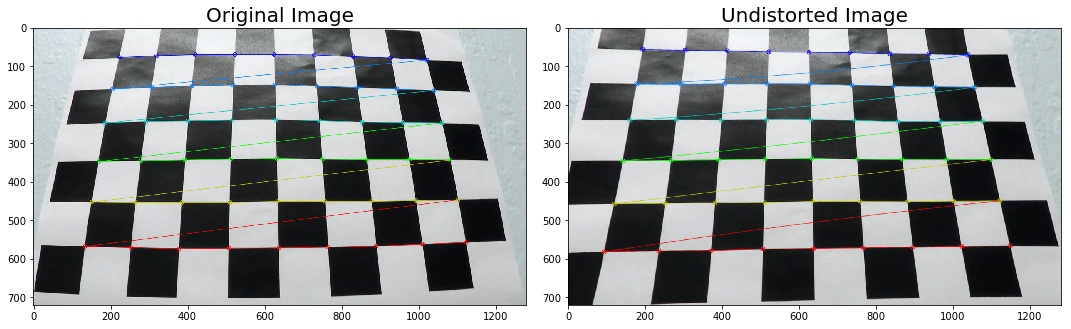

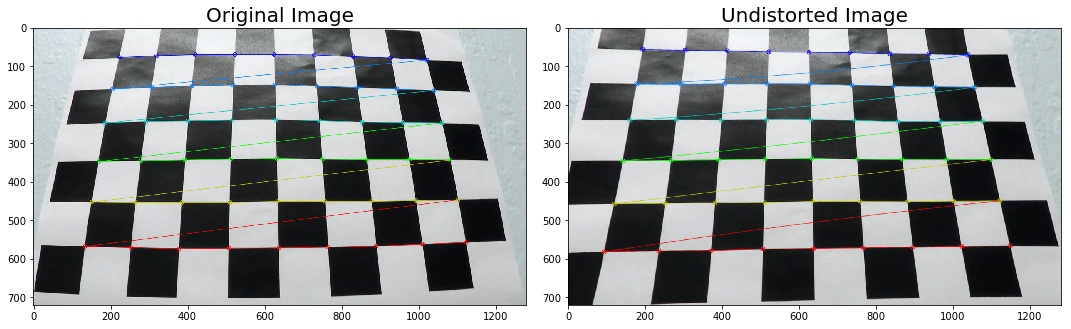

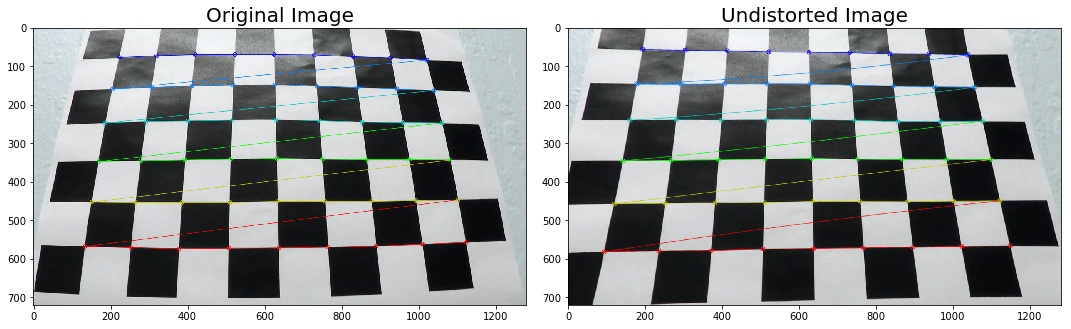

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [2]:
# Loading camera calibration
# Load calibration images that are stored the folder "camera_cal".
func = lambda imageFileName: {'name':imageFileName, 'data':cv2.imread(imageFileName)}
calib_files = glob.glob('./camera_cal/c*.jpg')
calibrationImages = list(map(func, calib_files))
num_imags = len(calibrationImages)

nx = 9
ny = 6

imgpoints = []
objpoints =[]
ideal_corners = camera.get_objpoints(nx,ny)

for cimg in calibrationImages:
    img = cimg['data']
    img_corners = camera.find_corners(img, nx=nx, ny=ny, draw=True)    
    if img_corners is not None:
        objpoints.append(ideal_corners)
        imgpoints.append(img_corners)
    else:
        print("Failed to find corner points in {}".format(cimg['name']))
print("{} of {} of calibration files are processed successfully".format(str(len(objpoints)),str(len(calib_files))))

# use cv2.calibrateCamera() to calculate the data necessary for undistorting an image
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

for img in calibrationImages:
    img = cimg['data']
    ## undistort image
    undistorted = camera.undistort_img(img, mtx, dist)
       
    ## plot the images
    viz.disply_transform(img, undistorted, "Original Image", "Undistorted Image")

Note that corners were not found in some images because the assumed nx, and ny for that images were not valid. It is possible to improve this code by adaptively adjusting nx and ny upon failure. But for the purpose of this project, the current results should be sufficient

# Pipeline of Single Image

The list below fo over a single image from the test system

8 test images are found
The following image is selected to demonstrate the functions of lane detection


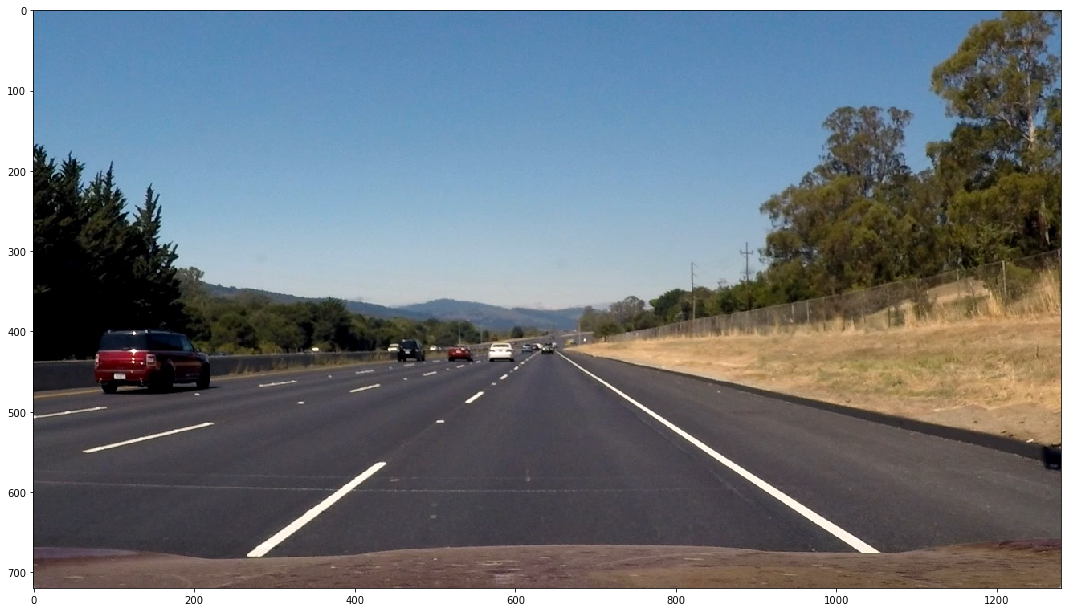

In [3]:
# load test images
func = lambda imageFileName: cv2.cvtColor(cv2.imread(imageFileName), cv2.COLOR_BGR2RGB)
sequence = glob.glob('./test_images/*.jpg')
testImages = list(map(func,sequence))
num_imags = len(testImages)
print("{} test images are found".format(str(num_imags)))
print("The following image is selected to demonstrate the functions of lane detection")

img = testImages[0]

viz.display_image(img)

## Apply a distortion correction to raw images

This stage performs the image undistortion using the camera matrix and distortion matrix obtained by in the "Camera Calibration" section in [2] 

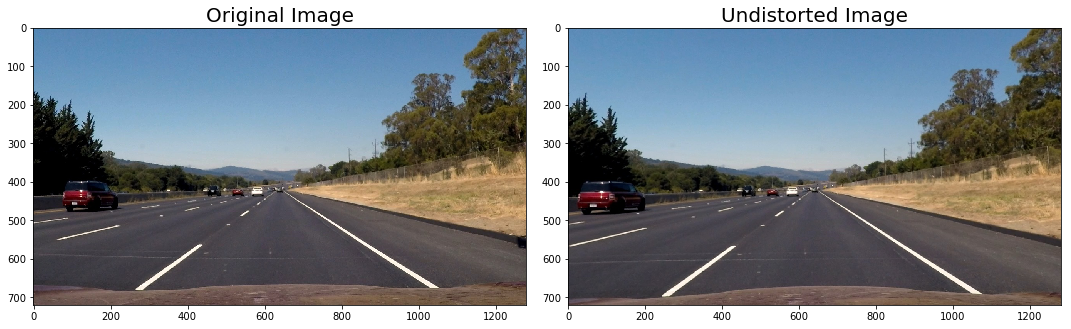

In [4]:
undistorted = camera.undistort_img(img, mtx, dist)
viz.disply_transform(img, undistorted, "Original Image", "Undistorted Image")

## Use color transforms, gradients, etc., to create a thresholded binary image.

This stage performs line detection using a combination of color and gradient detectors using sobel kernel. Detailed demonstration of those detectors is provided in "line_detector.ipynb" 

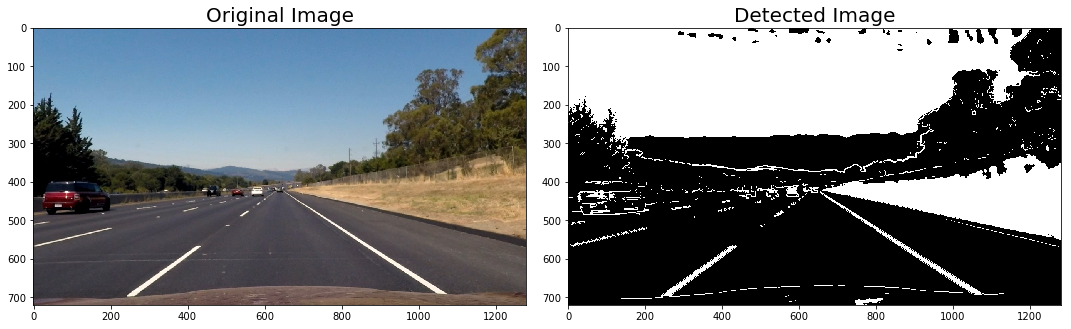

In [5]:
detected = pf.detector_pipeline(undistorted)
viz.disply_transform(undistorted, detected, "Original Image", "Detected Image")

## Apply a perspective transform to rectify binary image ("birds-eye view")

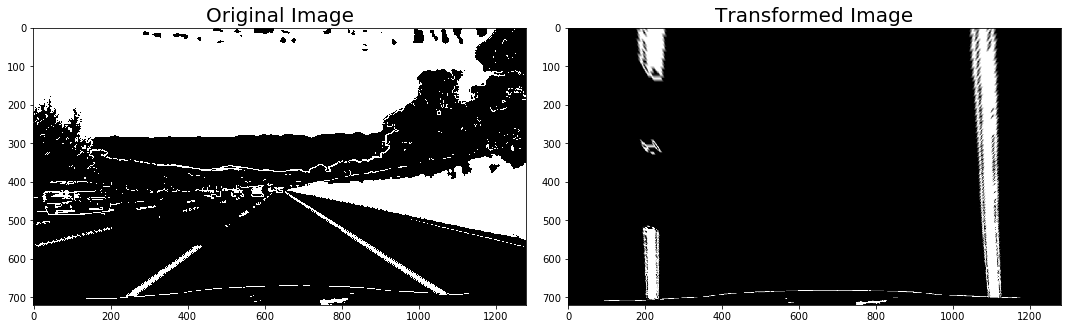

In [6]:
## transform image
transformed, _, inverse_matrix = pf.transform_image(detected)
viz.disply_transform(detected, transformed, "Original Image", "Transformed Image")

## Detect lane pixels and fit to find the lane boundary.
    

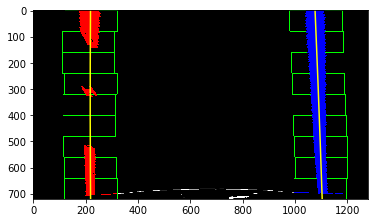

In [7]:
## transform image

points = pf.get_left_right_lane_points(transformed)
poly_fit = pf.polyfit(points)
f,ax = plt.subplots()
pf.visualize_poly2(ax, poly_fit, points)


## Determine the curvature of the lane and vehicle position with respect to center.
    

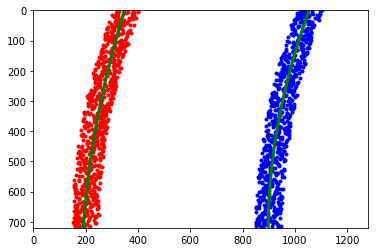

In [8]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [13]:
lpts = {'x':leftx,'y':ploty}
rpts = {'x':rightx,'y':ploty}
points = {'left':lpts, 'right':rpts}

actual = pf.calculate_curvature2((720,1280), points)
expected = [632.1, 626.2, 0]# Example values: 632.1 m    626.2 m
print(actual)
temp = np.linspace(0, 9, num=10)
# max y
print(np.max(temp))

[  6.19924372e+02   5.06886554e+02   1.00428571e-01]
9.0


In [30]:
measurements = pf.calculate_curvature2(np.shape(transformed), points)
print(measurements)

[  6.19924372e+02   5.06886554e+02   1.00428571e-01]


## Warp the detected lane boundaries back onto the original image.
    

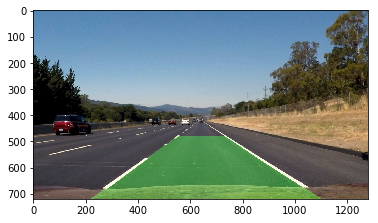

In [32]:
filled = pf.fill_area(img, detected, poly_fit, inverse_matrix)
f,ax = plt.subplots()
ax.imshow(filled)

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

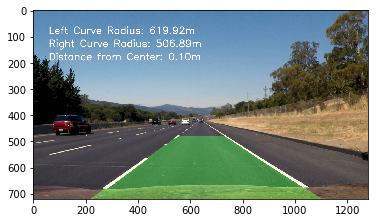

In [33]:
edited = pf.write_info(filled, measurements)
f,ax = plt.subplots()
ax.imshow(edited)

## Video pipeline

In [36]:
def lane_detector(img):
    undistorted = camera.undistort_img(img, mtx, dist)
    detected = pf.detector_pipeline(undistorted)
    transformed, _, inverse_matrix = pf.transform_image(undistorted)
    transformed_binary = pf.detector_pipeline(transformed)
    points = pf.get_left_right_lane_points(transformed_binary)
    poly_fit = pf.polyfit(points)
    measurements = pf.calculate_curvature2(np.shape(img), points)
    filled = pf.fill_area(img, detected, poly_fit, inverse_matrix)
    edited = pf.write_info(filled, measurements)
    return edited
   

In [37]:
# The images in test_images are for testing your pipeline on single frames. 

# To extract more test images from the videos, you can simply use an image writing method like cv2.imwrite(), 

# The output of each stage is saved in the folder called ouput_images, 
# The video called project_video.mp4 is the video your pipeline should work well on.


video_output = 'project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(lane_detector) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)



[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [46:57<00:02,  2.21s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 5h 40min 38s, sys: 51.4 s, total: 5h 41min 29s
Wall time: 46min 58s
